In [1]:
import os
import numpy as np
import pandas as pd
import h5py
import matlab.engine
import matlab
import nibabel as nb
import nipype.interfaces.freesurfer as fs
from nipype.interfaces.base import CommandLine
import matplotlib.pyplot as plt
from nilearn import plotting
import seaborn as sns


201217-13:15:15,461 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0


#### start matlab engine

In [2]:
def matlab_init_surfstat():
    global eng
    eng = matlab.engine.start_matlab()
    addpath = eng.addpath('../../BrainStat/surfstat/matlab')

matlab_init_surfstat()

#### read in QC file

In [3]:
qc_file = '../data/qualityControl_Bayrak_v01.xlsx'

df = pd.read_excel(qc_file, index_col=0)
df.index = df.index.map(str)

DF = df.copy(deep=True)

#DF

#### resample T1w-T2w-Ratios (native) to MNI Space (template)

In [4]:
subjlist = '../data/subjectList1200.txt'
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
subjlist = joinedlist = mylist[:-1]
len(subjlist)

1113

In [5]:
ddir = '../data/'
odir = '../data/hcp_MNI_T1wT2w/'


for subjid in subjlist:

    # existing files
    t1t2_native = os.path.join(ddir, 
                               'hcp-structural-preprocessed/%s/T1w/T1wDividedByT2w.nii.gz' 
                               % (subjid))
    t1_native   = os.path.join(ddir, 
                               'hcp-structural-preprocessed/%s/T1w/T1w_acpc_dc.nii.gz' 
                               %(subjid))
    t1_mni_trf  = os.path.join(ddir, 
                               'hcp_MNI_T1w/%s/MNINonLinear/xfms/acpc_dc2standard.nii.gz' 
                               % (subjid))

    fsl_mni     = '../data/MNI152_T1_1mm_brain.nii.gz'

    # will be generated 
    if not os.path.exists(os.path.join(odir, subjid)):
        os.makedirs(os.path.join(odir, subjid))
        
    t1t2_mni = os.path.join(odir, subjid, 'T1wDividedByT2w_mni.nii.gz')


    # Here we go...
    if os.path.isfile(t1t2_native) and os.path.isfile(t1_native) \
    and os.path.isfile(t1_mni_trf) and not os.path.isfile(t1t2_mni):        

        print(subjid)

        # nipype wrapper for $wb_command
        cli = CommandLine(command = 'wb_command')
        cli.inputs.args = ('-volume-warpfield-resample %s %s %s  ENCLOSING_VOXEL %s -fnirt %s ' 
                           % (t1t2_native, t1_mni_trf, fsl_mni, t1t2_mni, t1_native))
        cli.run()    


### resample T1w-T2w-Ratios (MNI) along hippocampus surfaces

In [6]:
bladesdir = '../data/bladesMni/'
workdir   = '../data/bladesMniGifti_T1wT2w/'
t1t2dir   = '../data/hcp_MNI_T1wT2w/'

subjlist = '../data/subjectList1200.txt'
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
subjlist = joinedlist = mylist[:-1]
len(subjlist)


1113

In [7]:
roi_strings = ['L_SUB', 'L_CA', 'L_DG', 'R_SUB', 'R_CA', 'R_DG']                                        

for subjid in subjlist:

    for roi in roi_strings:
    
        # get existing files
        fname     = os.path.join(bladesdir, 'HCP_%s_%s_skelFinal.obj' % (subjid, roi))  
        volfile   = os.path.join(t1t2dir, subjid, 'T1wDividedByT2w_mni.nii.gz')

        if os.path.isfile(fname) and os.path.isfile(volfile): 

            # ... will be generated
            fsFile    = os.path.join(workdir, os.path.basename(fname)[:-4] + '.fs')
            giftiFile = os.path.join(workdir, os.path.basename(fname)[:-4] + '.surf.gii')
            vol2hipp  = os.path.join(workdir, os.path.basename(fname)[:-4] + '.shape.gii')

            if not os.path.isfile(vol2hipp):

                # read hippocampal surface (*obj) and write in freesurfer format (*fs)
                data = eng.SurfStatReadSurf(fname)
                eng.SurfStatWriteSurf1(fsFile, data);

                # nipype wrapper for $ mris_convert
                mris = fs.MRIsConvert()
                mris.inputs.in_file  = fsFile
                mris.inputs.out_file = giftiFile
                mris.run() 

                # nipype wrapper for $wb_command
                cli = CommandLine(command = 'wb_command')
                cli.inputs.args = ('-volume-to-surface-mapping %s %s %s  -trilinear ' 
                                   % (volfile, giftiFile, vol2hipp))
                cli.run()

                # read data from the gifti file
                qc_data = nb.load(vol2hipp).agg_data()




### write in the qc file (t1w-t2w-ratios)

In [8]:
workdir   = '../data/bladesMniGifti_T1wT2w/'

for subjid in subjlist:

    # filename for t1w-t2w ratio, resampled along hippocampus
    vol2hipp_L_SUB = os.path.join(workdir, 'HCP_%s_L_SUB_skelFinal.shape.gii' % (subjid))  
    vol2hipp_R_SUB = os.path.join(workdir, 'HCP_%s_R_SUB_skelFinal.shape.gii' % (subjid))  
    vol2hipp_L_DG  = os.path.join(workdir, 'HCP_%s_L_DG_skelFinal.shape.gii' % (subjid))  
    vol2hipp_R_DG  = os.path.join(workdir, 'HCP_%s_R_DG_skelFinal.shape.gii' % (subjid))  
    vol2hipp_L_CA  = os.path.join(workdir, 'HCP_%s_L_CA_skelFinal.shape.gii' % (subjid))  
    vol2hipp_R_CA  = os.path.join(workdir, 'HCP_%s_R_CA_skelFinal.shape.gii' % (subjid))  

    if os.path.isfile(vol2hipp_L_SUB): 
        # read data from the gifti file
        qc_data_L_SUB = nb.load(vol2hipp_L_SUB).agg_data()
        # set mean t1w-t2w ratios at dataframe
        DF.at[subjid, 't1-t2-LSUB'] = qc_data_L_SUB.mean()

    if os.path.isfile(vol2hipp_R_SUB):
        qc_data_R_SUB = nb.load(vol2hipp_R_SUB).agg_data()
        DF.at[subjid, 't1-t2-RSUB'] = qc_data_R_SUB.mean()
    
    if os.path.isfile(vol2hipp_L_DG):
        qc_data_L_DG  = nb.load(vol2hipp_L_DG).agg_data()
        DF.at[subjid, 't1-t2-LDG']  = qc_data_L_DG.mean()
        
    if os.path.isfile(vol2hipp_R_DG):
        qc_data_R_DG  = nb.load(vol2hipp_R_DG).agg_data()
        DF.at[subjid, 't1-t2-RDG']  = qc_data_R_DG.mean()
        
    if os.path.isfile(vol2hipp_L_CA):
        qc_data_L_CA  = nb.load(vol2hipp_L_CA).agg_data()
        DF.at[subjid, 't1-t2-LCA']  = qc_data_L_CA.mean()
        
    if os.path.isfile(vol2hipp_R_CA):
        qc_data_R_CA  = nb.load(vol2hipp_R_CA).agg_data()
        DF.at[subjid, 't1-t2-RCA']  = qc_data_R_CA.mean()


In [9]:
#DF

### potential identifier for "bad" segmentations

In [10]:
colstoplot = ['t1-t2-LSUB', 't1-t2-RSUB', 't1-t2-LDG', 't1-t2-RDG', 't1-t2-LCA', 't1-t2-RCA']

for col in colstoplot:
    noindex = DF[DF[col] > (DF[col].mean() + 3 * DF[col].std())].index.tolist()
    print(col, len(noindex))
    print(noindex)
    for noidx in noindex:
        DF.at[noidx, 't1-t2-no'] = 0

t1-t2-LSUB 10
['111514', '126931', '161327', '178647', '187143', '549757', '592455', '644044', '693764', '814649']
t1-t2-RSUB 12
['129028', '145531', '155231', '156637', '161327', '198249', '223929', '397861', '549757', '592455', '644044', '814649']
t1-t2-LDG 9
['109123', '126931', '145127', '161327', '188549', '303119', '650746', '656657', '814649']
t1-t2-RDG 13
['113922', '145531', '155938', '161327', '163331', '169343', '223929', '298051', '303119', '592455', '810439', '814649', '878776']
t1-t2-LCA 10
['118225', '150019', '158338', '162228', '174841', '182436', '182739', '187143', '644044', '814649']
t1-t2-RCA 9
['118932', '131621', '223929', '303119', '592455', '644044', '715950', '814649', '894673']


# plot distribution of mean T1w-T2w-Ratios

0 t1-t2-LSUB
1 t1-t2-RSUB
2 t1-t2-LDG
3 t1-t2-RDG
4 t1-t2-LCA
5 t1-t2-RCA


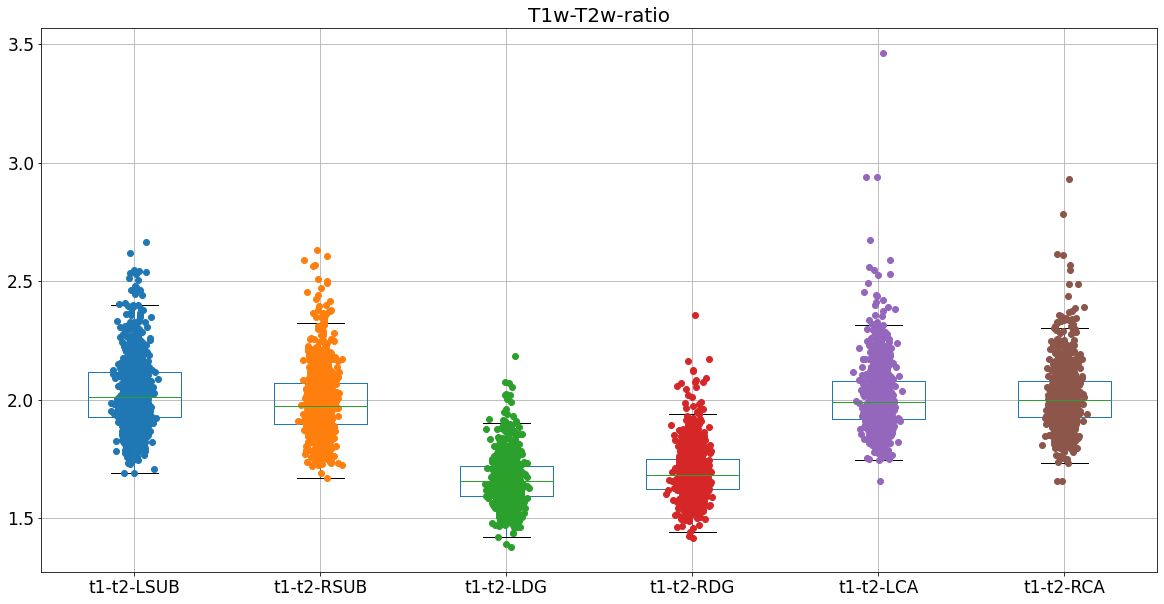

In [12]:
colstoplot = ['t1-t2-LSUB', 't1-t2-RSUB', 't1-t2-LDG', 't1-t2-RDG', 't1-t2-LCA', 't1-t2-RCA']

ax = DF.boxplot(column=colstoplot,
           figsize=(20,10),
           fontsize=17, 
           showfliers=False)

ax.set_title("T1w-T2w-ratio", fontsize=20)

for i,d in enumerate(colstoplot):
    print(i, d)
    y = DF[d]
    x = np.random.normal(i+1, 0.04, len(y))
    plt.plot(x, y, 
             marker="o", linestyle="None")


#plt.savefig('../figures/qc/t1t2-ratios-mean.png', dpi=300)

### for MANUAL visualizing purposes, T1w_restore (mni) resampled along hippocampus shells

In [13]:
shellsdir = '../data/shellsMni/'
outdir    = '../data/shellsMniGifti'
t1dir     = '../data/hcp_MNI_T1w/'

subjlist = '../data/subjectList1200.txt'
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
subjlist = joinedlist = mylist[:-1]
len(subjlist)

1113

### L_SUB, L_CA, L_DG, R_SUB, R_CA, R_DG gifti

In [14]:
roi_strings = ['L_SUB', 'L_CA', 'L_DG', 'R_SUB', 'R_CA', 'R_DG']                                        

for subjid in subjlist:

    for roi in roi_strings:

        # get existing files
        fname     = os.path.join(shellsdir, 'HCP_%s_%s.obj' % (subjid, roi))  
        volfile   = os.path.join(t1dir, subjid, 'MNINonLinear/T1w_restore.nii.gz')

        if os.path.isfile(fname) and os.path.isfile(volfile): 

            # ... will be generated
            fsFile    = os.path.join(outdir, os.path.basename(fname)[:-4] + '.fs')
            giftiFile = os.path.join(outdir, os.path.basename(fname)[:-4] + '.surf.gii')
            vol2hipp  = os.path.join(outdir, os.path.basename(fname)[:-4] + '.shape.gii')

            if not os.path.isfile(vol2hipp):

                # read hippocampal surface (*obj) and write in freesurfer format (*fs)
                data = eng.SurfStatReadSurf(fname)
                eng.SurfStatWriteSurf1(fsFile, data);

                # nipype wrapper for $ mris_convert
                mris = fs.MRIsConvert()
                mris.inputs.in_file  = fsFile
                mris.inputs.out_file = giftiFile
                mris.run() 

                # nipype wrapper for $wb_command
                cli = CommandLine(command = 'wb_command')
                cli.inputs.args = ('-volume-to-surface-mapping %s %s %s  -trilinear ' 
                                   % (volfile, giftiFile, vol2hipp))
                cli.run()


### read & write man vis. quality check in QC template

In [15]:
qc_file = '../data/qualityControl_Bayrak_v02_manual.xlsx'

dfMAN = pd.read_excel(qc_file, index_col=0)
dfMAN.index = dfMAN.index.map(str)

DFMAN = dfMAN.copy(deep=True)

subjlist = DF.index
for subj in subjlist:
    if DFMAN.at[subj, 't1-t2-man-viz'] == 1:
        DF.at[subj, 't1-t2-man-viz'] = 1
    elif DFMAN.at[subj, 't1-t2-man-viz'] == 0:
        DF.at[subj, 't1-t2-man-viz'] == 0

In [16]:
#DF

### input PNAS study QC values in our DF

In [17]:
qc_file_pnas = '../data/qualityControl_VosdeWael.xlsx'

df_pnas = pd.read_excel(qc_file_pnas, index_col=0)
df_pnas.index = df_pnas.index.map(str)

DF_pnas = df_pnas.copy(deep=True)


In [18]:
for subjid in subjlist:

    if subjid in DF_pnas.index :
        
        if DF_pnas.at[subjid, 'Grade'] > 0: 
            
            DF.at[subjid, 'pnas'] = 1
    
        elif DF_pnas.at[subjid, 'Grade'] <= 0: 
            
            DF.at[subjid, 'pnas'] = 0
    
    

In [19]:
#DF

# check whether each subject has 4 scans

In [20]:
# data dir
ddir     = '../data/'  
                
glassdir = os.path.join(ddir, 'glasserTimeseries/');    # cortex t-series
hippdir  = os.path.join(ddir, 'smoothTimeseries/');     # hippocampus t-series


subjlist = '../data/subjectList1200.txt'
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
subjlist = joinedlist = mylist[:-1]
len(subjlist)


1113

In [21]:
# it is HCP data, so there will be 4 scans
scans = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 
         'rfMRI_REST2_LR', 'rfMRI_REST2_RL'];

# hippocampus segmentations
rois = ['L_SUB', 'L_CA', 'L_DG', 'R_SUB', 'R_CA', 'R_DG']

j = 0

for subjid in subjlist:

    objname1 = os.path.join(ddir, 'bladesMni/HCP_%s_L_SUB_skelFinal.obj' % (subjid))
    objname2 = os.path.join(ddir, 'bladesMni/HCP_%s_R_SUB_skelFinal.obj' % (subjid))
    objname3 = os.path.join(ddir, 'bladesMni/HCP_%s_L_DG_skelFinal.obj' % (subjid))
    objname4 = os.path.join(ddir, 'bladesMni/HCP_%s_R_DG_skelFinal.obj' % (subjid))
    objname5 = os.path.join(ddir, 'bladesMni/HCP_%s_L_CA_skelFinal.obj' % (subjid))
    objname6 = os.path.join(ddir, 'bladesMni/HCP_%s_R_CA_skelFinal.obj' % (subjid))

    # check if segmentation files exist
    if os.path.isfile(objname1) and os.path.isfile(objname2) \
    and os.path.isfile(objname3) and os.path.isfile(objname4) \
    and os.path.isfile(objname5) and os.path.isfile(objname6):


        # check if timeseries exist
        subj_glass_file = os.path.join(glassdir, 'HCP_%s_glasserTimeseries.mat' % (subjid))
        subj_hipp_file  = os.path.join(hippdir, 'HCP_%s_smoothTimeseries.mat' % (subjid))

        if os.path.isfile(subj_glass_file) and os.path.isfile(subj_hipp_file):

            #  HDF reader for matlab v7.3 files
            f_subj_glass = h5py.File(subj_glass_file, 'r')
            f_subj_hipp  = h5py.File(subj_hipp_file, 'r')

            # check the data for each of the 4 scans
            scan_check = []
            for scan in scans:
                if scan in f_subj_glass.keys():
                    scan_check.append(True)

            if len(scan_check) == 4:
                DF.at[subjid, '4scans'] = int(1)
            else:
                print(subjid, 'does not have 4 scans')
                DF.at[subjid, '4scans'] = int(0)
            
            j += 1


250427 does not have 4 scans
270332 does not have 4 scans
334635 does not have 4 scans
633847 does not have 4 scans
638049 does not have 4 scans


In [22]:
#DF

# count subjects with 4scans

In [23]:
subjlist = DF.index
DF.columns
i = 0
for subj in subjlist:
    if DF.at[subj, '4scans'] == 1:
        i += 1
    elif DF.at[subj, '4scans'] == 0:
        print(subj)

250427
270332
334635
633847
638049


In [24]:
i

822

# count subjects with HCP issues

In [25]:
k = 0    
for subj in subjlist:
    if DF.at[subj, '4scans'] == 1:     
        if not pd.isnull(DF.at[subj, 'HCP-issues']):
            k += 1
            print(subj, DF.at[subj, 'HCP-issues'])

105620 A
110613 AB
111312 A
112112 A
122620 A
124422 A
134829 A
139637 AB
140117 A
145127 A
147737 A
148840 A
156435 A
163432 A
166438 A
168139 AB
175035 B
176239 B
178849 A
180836 A
181131 A
195849 A
199655 A
199958 B
201515 AB
224022 A
415837 B
433839 AB
465852 B
522434 A
628248 A
656657 AB
709551 A
734045 A
767464 AB
872764 B
958976 A
965367 B
987983 B
994273 AB


In [26]:
k

40

In [27]:
i - k

782

# count subjects with bad hippocampus segmentations

In [28]:
m = 0    
for subj in subjlist:
    if DF.at[subj, '4scans'] == 1:     
        if pd.isnull(DF.at[subj, 'HCP-issues']):
            if DF.at[subj, 'pnas'] > 0  or DF.at[subj, 't1-t2-man-viz'] == 1: 
                m += 1
                DF.at[subj, 'inclusion'] = 1

In [29]:
m

740

In [30]:
#DF

In [31]:
DF.to_excel('../data/qualityControl_Bayrak_v03.xlsx')

### check surviving subjects..

In [32]:
qc_file = '../data/qualityControl_Bayrak_v03.xlsx'

df = pd.read_excel(qc_file, index_col=0)
df.index = df.index.map(str)

DF = df.copy(deep=True)


In [33]:
subjlist = DF.index

In [35]:
f1 = open('../data/subjectListS900_QC.txt', 'a')

x = 0
for subj in subjlist:
    if DF.at[subj, 'inclusion'] == 1:
        x += 1
        f1.write(subj + "\n")
f1.close()

In [36]:
x

740

### check the correlation of (individual, mean)

In [37]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns


In [38]:
ddir      = '../data/'                                          #  data dir
cordir    = '../data/tout_cortex/'
grodir    = '../data/tout_group'

# final subject list after QC         
subjlist = os.path.join(ddir, 'subjectListS900_QC.txt');       # 740 subjects
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
mylist =  mylist[:-1] 
totnum = len(mylist)

print('We have now %i subjects... ' % totnum)


We have now 740 subjects... 


In [39]:
len(mylist)

740

In [40]:
# get group-level cortex-to-subfield connectivity

with h5py.File(os.path.join(grodir, 'cortex740_LSUB.h5'), "r") as f:  
    avg_LSUB = np.array(f['LSUB']) 

with h5py.File(os.path.join(grodir, 'cortex740_RSUB.h5'), "r") as f:  
    avg_RSUB = np.array(f['RSUB']) 

with h5py.File(os.path.join(grodir, 'cortex740_LCA.h5'), "r") as f:  
    avg_LCA = np.array(f['LCA']) 

with h5py.File(os.path.join(grodir, 'cortex740_RCA.h5'), "r") as f:  
    avg_RCA = np.array(f['RCA']) 

with h5py.File(os.path.join(grodir, 'cortex740_LDG.h5'), "r") as f:  
    avg_LDG = np.array(f['LDG']) 
    
with h5py.File(os.path.join(grodir, 'cortex740_RDG.h5'), "r") as f:  
    avg_RDG = np.array(f['RDG']) 
    
avg_SUB = (avg_LSUB + avg_RSUB)/2
avg_CA  = (avg_LCA + avg_RCA)/2
avg_DG  = (avg_LDG + avg_RDG)/2



In [41]:
mysubjects = mylist
mycols = ['SUB', 'CA', 'DG', 'corr']

df = pd.DataFrame(index = mysubjects,
                  columns = mycols)


In [42]:
#df

In [43]:
num = avg_SUB.shape[0]

k = 0
for subjID in mysubjects:
    
    subjsub_L = os.path.join(cordir, subjID + '_cortex_LSUB.h5')
    subjsub_R = os.path.join(cordir, subjID + '_cortex_RSUB.h5')
    
    with h5py.File(subjsub_L, "r") as f:        
        subjsubdata_L = np.array(f[subjID])
    
    with h5py.File(subjsub_R, "r") as f:        
        subjsubdata_R = np.array(f[subjID])

    subjsubdata = (subjsubdata_L + subjsubdata_R) / 2   
    
    subjca_L = os.path.join(cordir, subjID + '_cortex_LCA.h5')
    subjca_R = os.path.join(cordir, subjID + '_cortex_RCA.h5')
    
    with h5py.File(subjca_L, "r") as f:        
        subjcadata_L = np.array(f[subjID])

    with h5py.File(subjca_R, "r") as f:        
        subjcadata_R = np.array(f[subjID])

    subjcadata = (subjcadata_L + subjcadata_R) / 2      
    
    subjdg_L = os.path.join(cordir, subjID + '_cortex_LDG.h5')
    subjdg_R = os.path.join(cordir, subjID + '_cortex_RDG.h5')
    
    with h5py.File(subjdg_L, "r") as f:        
        subjdgdata_L = np.array(f[subjID])

    with h5py.File(subjdg_R, "r") as f:        
        subjdgdata_R = np.array(f[subjID])
    
    subjdgdata = (subjdgdata_L + subjdgdata_R) / 2      
    
    iC = df.index.get_loc(subjID)
    df.iloc[iC]['SUB'] = pearsonr(avg_SUB.reshape(num), subjsubdata.reshape(num))[0]
    df.iloc[iC]['CA']  = pearsonr(avg_CA.reshape(num), subjcadata.reshape(num))[0]
    df.iloc[iC]['DG']  = pearsonr(avg_DG.reshape(num), subjdgdata.reshape(num))[0]

    if df.iloc[iC]['SUB'] >= 0.45 and df.iloc[iC]['CA'] >= 0.45 and df.iloc[iC]['DG'] >=0.45:
        k += 1
        df.iloc[iC]['corr'] = 1    
    
    

In [44]:
df.to_excel('../data/tout_group/cortex_corr_indiv.xlsx')

In [45]:
df_file = '../data/tout_group/cortex_corr_indiv.xlsx'

DF = pd.read_excel(df_file, index_col=0)
DF.index = DF.index.map(str)

0 SUB
1 CA
2 DG


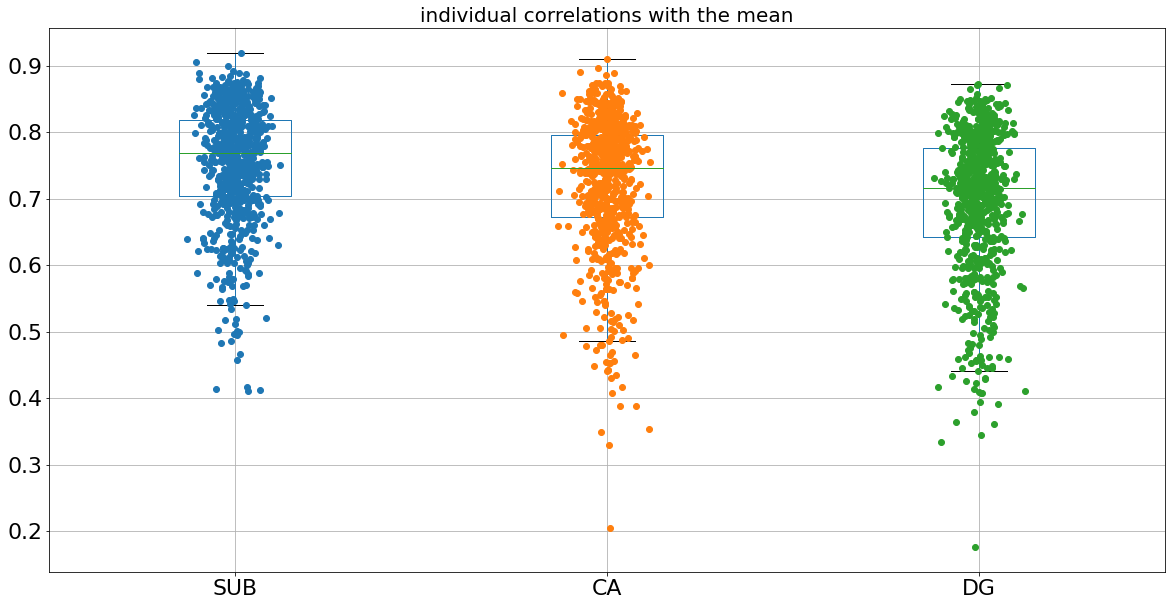

In [46]:
# plot n=740 

colstoplot = ['SUB', 'CA', 'DG']

ax = DF.boxplot(column=colstoplot,                        
               figsize=(20,10),
               fontsize=22, 
               showfliers=False)

ax.set_title("individual correlations with the mean", fontsize=20)

for i,d in enumerate(colstoplot):
    print(i, d)
    y = DF[d]
    x = np.random.normal(i+1, 0.04, len(y))
    plt.plot(x, y, 
             marker="o", linestyle="None")

#plt.savefig('../figures/individual_correlations.png', dpi=300)


# exclude subjects below r<0.45 for gradient analysis

In [47]:
exc_file = '../data/qualityControl_Bayrak_v03.xlsx'
exc = pd.read_excel(exc_file, index_col=0)
exc.index = exc.index.map(str)

In [48]:
len(exc[exc['inclusion'] == 1])

740

### create new df

In [49]:
mysubjects = mylist
mycols = ['HCP-issues', 'pnas', 't1-t2-LSUB', 't1-t2-RSUB', 't1-t2-LDG',
       't1-t2-RDG', 't1-t2-LCA', 't1-t2-RCA', 't1-t2-no', 't1-t2-man-viz',
       '4scans', 'inclusion', 'corrSUB', 'corrCA', 'corrDG', 'inclusion_gr']

inc = pd.DataFrame(index = mysubjects,
                    columns = mycols)


In [50]:
inc['HCP-issues'] = exc['HCP-issues'] 
inc['pnas'] = exc['pnas']
inc['t1-t2-LSUB'] = exc['t1-t2-LSUB']
inc['t1-t2-RSUB'] = exc['t1-t2-RSUB']
inc['t1-t2-LDG'] = exc['t1-t2-LDG']
inc['t1-t2-RDG'] = exc['t1-t2-RDG']
inc['t1-t2-LCA'] = exc['t1-t2-LCA']
inc['t1-t2-RCA'] = exc['t1-t2-RCA']
inc['t1-t2-no'] = exc['t1-t2-no']
inc['t1-t2-man-viz'] = exc['t1-t2-man-viz']
inc['4scans'] = exc['4scans']
inc['inclusion'] = exc['inclusion']
inc['corrSUB'] = df['SUB']
inc['corrCA'] = df['CA']
inc['corrDG'] = df['DG']

In [51]:
len(inc[inc['inclusion'] == 1])

740

In [52]:
m = 0
for subjID in mysubjects:
    if df.at[subjID, 'corr'] == 1 and inc.at[subjID, 'inclusion'] == 1:
        inc.at[subjID, 'inclusion_gr'] = 1
        m += 1

In [53]:
len(inc[inc['inclusion_gr'] ==1 ])

709

In [54]:
inc.to_excel('../data/qualityControl_Bayrak_v04.xlsx')

# save subject id's for gradient analysis

In [65]:
f1 = open('../data/subjectListS900_QC_gr.txt', 'a')

x = 0
for subjID in mysubjects:
    if inc.at[subjID, 'inclusion_gr'] == 1:
        x += 1
        f1.write(subjID + "\n")
f1.close()

In [66]:
x

709

# final check

In [67]:
filename = '../data/qualityControl_Bayrak_v04.xlsx'
check    = pd.read_excel(filename, index_col=0)
check.index = check.index.map(str)

In [68]:

h = 0
for subjID in check.index:
    if check.at[subjID, 'inclusion'] == 1 and check.at[subjID, 'inclusion_gr'] != 1:
        h += 1
        
        print(subjID)


111716
148032
149236
154835
162935
167238
171431
180129
192035
195041
197348
204521
211720
284646
309636
310621
391748
429040
436239
449753
525541
599671
615744
617748
715950
727553
735148
773257
786569
837964
843151


In [69]:
h

31

In [61]:
#check

### add demographics

In [70]:
# get HCP - S900 subject list        
subjlist = '../data/subjectListS900_QC_gr.txt'
f = open(subjlist); mylist = f.read().split("\n"); f.close() 
subjlist = joinedlist = mylist[:-1]

len(subjlist)

709

In [71]:
check['age'] = pd.Series(index=check.index)
check['sex'] = np.nan 
check = check.astype({"sex": str}) 

/data/u_bayrak_software/anaconda2/envs/hippoc/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [72]:
HCP_u = pd.read_csv('../data/HCP_solar/HCP_s1200_unrestricted.csv', 
                    index_col = 0)

HCP_u.index = HCP_u.index.map(str)

HCP_r = pd.read_csv('../data/HCP_solar/HCP_s1200_restricted.csv', 
                    index_col = 0)

HCP_r.index = HCP_r.index.map(str)

In [73]:
female = 0

for subjID in subjlist:
    
    iA = HCP_r.index.get_loc(subjID)
    iB = HCP_u.index.get_loc(subjID)
    iC = check.index.get_loc(subjID)

    check.at[subjID, 'age'] = HCP_r.iloc[iA]['Age_in_Yrs']
    check.at[subjID, 'sex'] = HCP_u.iloc[iB]['Gender']

    if check.at[subjID, 'sex'] == 'F':
        female += 1

In [74]:
check['age'].mean(), check['age'].std()

(28.708039492242595, 3.7224627681932634)

In [75]:
female

395

In [76]:
check.to_excel('../data/qualityControl_Bayrak_v04.xlsx')